In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import xsar
import xrft
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from leakage.velocity_leakage import * #S1DopplerLeakage, add_dca_to_leakage_class, slant2ground, low_pass_filter_2D_dataset, low_pass_filter_2D
from leakage.misc import round_to_hour, angular_difference, calculate_distance, power_spectrum_custom

func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
storage_dir = "data_processed/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] # drop outdated
try:
    scenarios.pop(scenarios.index('Aghulas_20200121'))
except:
    pass

scenarios = ['Carrib_20231104']

In [12]:
beam_pattern = "phased_array"
az_mask_cutoffs = [10e3, 20e3, 40e3, 60e3, 80e3, 100e3, 130e3, 160e3]


perf_phased_arrays2 = []


for scenario in scenarios:

    perf_phased_arrays = []

    for az_mask_cutoff in az_mask_cutoffs:

        # ----------------------------------------
        files = glob.glob(f"{data_dir+scenario}/*.SAFE")

        # observation = S1DopplerLeakage(
        #     filename=files,    
        #     # era5_file='era5_winds/era5_wind_202011.nc',
        #     era5_directory= 'era5_winds/',
        #     scene_size=25_000,
        #     az_mask_cutoff=az_mask_cutoff, 
        #     vx_sat=8000,
        #     PRF=4,
        #     resolution_spatial=200,
        #     antenna_length=3.2,
        #     beam_pattern=beam_pattern, # ["sinc", "phased_array"]
        #     _speckle_noise = False
        #     )
        observation = S1DopplerLeakage(
            filename=files,
            # f0=26.5e9,
            z0 = 823_000,
            era5_directory='../../data/leakage/era5_winds/',
            resolution_product=50_000,
            az_footprint_cutoff=az_mask_cutoff,
            vx_sat=6_800,
            PRF=4,
            grid_spacing=75,
            antenna_length=2.87,
            antenna_height=0.32,
            beam_pattern= 'phased_array', #'phased_array', sinc
            antenna_elements=4,
            antenna_weighting=0.75,
            swath_start_incidence_angle_scat=35,
            boresight_elevation_angle_scat=40,
            random_state = 42,
            fill_nan_limit = 1,
            product_averaging_window='hann',
            # _interpolator = 'linear',

            # era5_smoothing_window=30,
            # denoise = True,
            # _pulsepair_noise = True
            # _speckle_noise= False
            )
    
        # clipping is performed such that the same data is analysed regardless of choosen az_mask_cutoff
        # else a greater cutoff would analyse a smaller area of interest as more is clipped at the borders
        observation.open_data()
        clip_ref = int(np.max(az_mask_cutoffs)/observation.resolution_product)
        clip = clip_ref - int(observation.az_footprint_cutoff/observation.resolution_product)
        observation.S1_file = observation.S1_file.isel(line = slice(clip, -clip -1 ))
        
        observation.querry_era5()
        observation.wdir_from_era5()
        observation.create_dataset()
        observation.create_beam_mask()
        observation.compute_scatt_eqv_backscatter()
        observation.compute_beam_pattern()
        observation.compute_leakage_velocity()
        observation.compute_leakage_velocity_estimate()

        phased_array = observation.data.V_leakage_pulse_rg_subscene
        phased_array_inverted = observation.data.V_leakage_pulse_rg_subscene_inverted
        diff_phased_array = phased_array - phased_array_inverted
        perf_phased_array = np.sqrt(np.nanmean(diff_phased_array**2))
        perf_phased_arrays.append(perf_phased_array)

    perf_phased_arrays2.append(perf_phased_arrays)
            

/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:508: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202311.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202311.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202311.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202311.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202311.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202311.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202311.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202311.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Text(0.5, 0, 'Azimuthal ground footprint cutoff [m]')

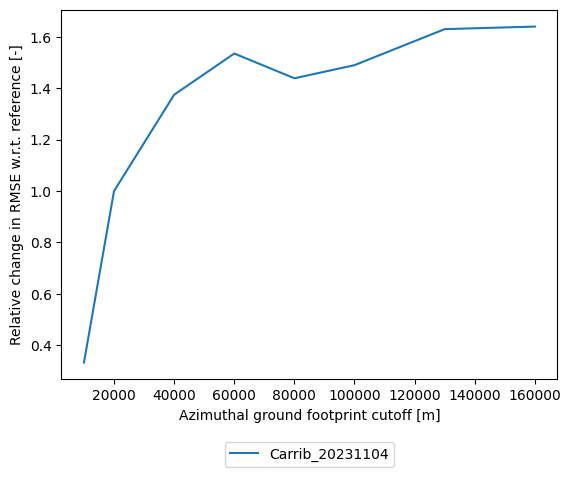

In [13]:
df = pd.DataFrame(perf_phased_arrays2, columns = az_mask_cutoffs, index= scenarios).transpose()
df_divided = df.div(df.iloc[1, :], axis=1)
# df_divided.plot()
ax = df_divided.plot()

# Customize the legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax.set_ylabel('Relative change in RMSE w.r.t. reference [-]')
ax.set_xlabel('Azimuthal ground footprint cutoff [m]')


In [14]:
df

,Carrib_20231104
10000.0,0.081577
20000.0,0.245379
40000.0,0.337455
60000.0,0.376832
80000.0,0.353189
100000.0,0.365711
130000.0,0.400137
160000.0,0.402588
